=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===

=== SCENARIO SUMMARY ===
              soy_land_pc  total_land_pc   water_pc  protein_pc
scenario                                                       
Current            312.46         981.85  815306.28       28.43
Red meat cap       225.08         659.77  544023.72       22.21
50/50              200.68         447.16  397204.69       22.00
40/60              194.95         399.34  363072.20       22.00

=== Full Scenario Summary Table ===
              soy_land_pc  total_land_pc   water_pc  protein_pc  beef_kg  \
scenario                                                                   
Current            312.46         981.85  815306.28       28.43    14.90   
Red meat cap       225.08         659.77  544023.72       22.21     2.98   
50/50              200.68         447.16  397204.69       22.00     1.79   
40/60              194.95         399.34  363072.20       22.00     1.38   

              chicken_kg  dairy_kg  eggs_kg  

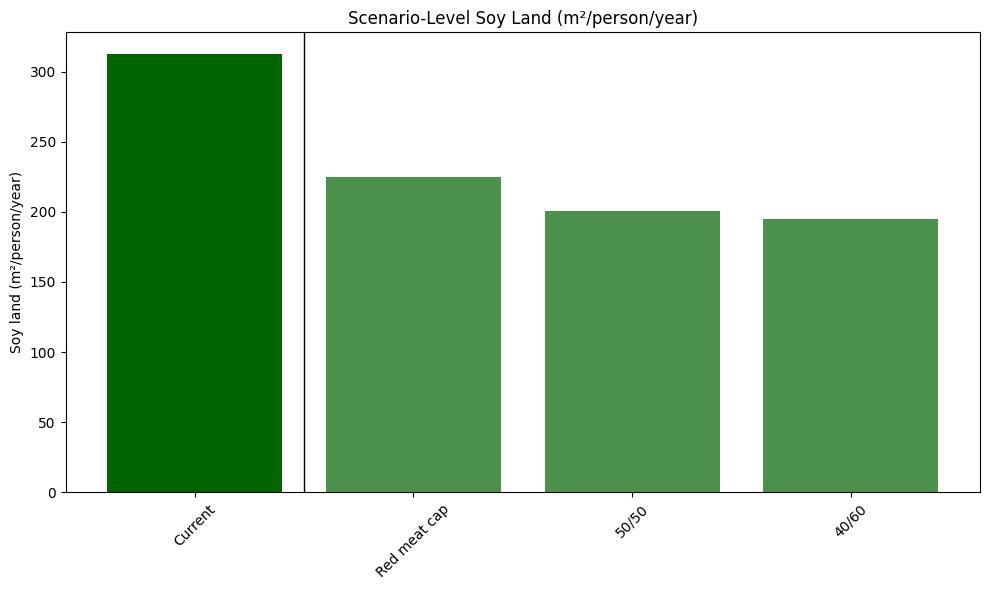

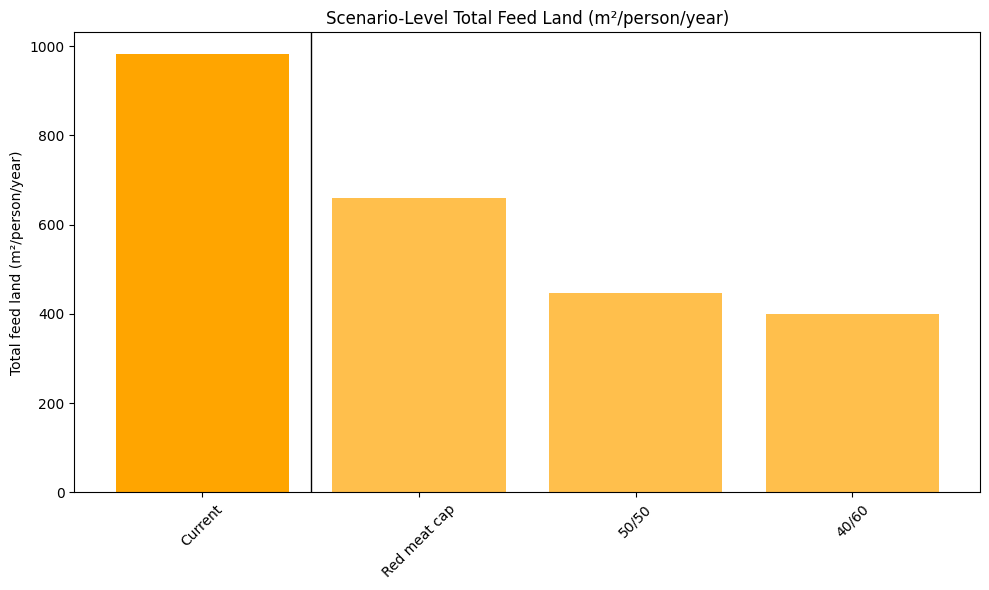

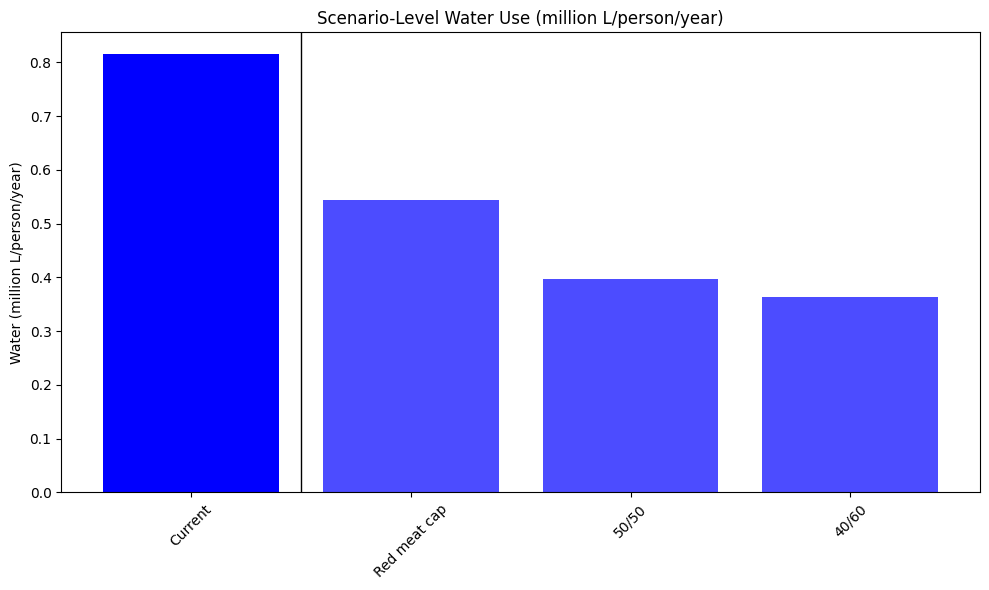

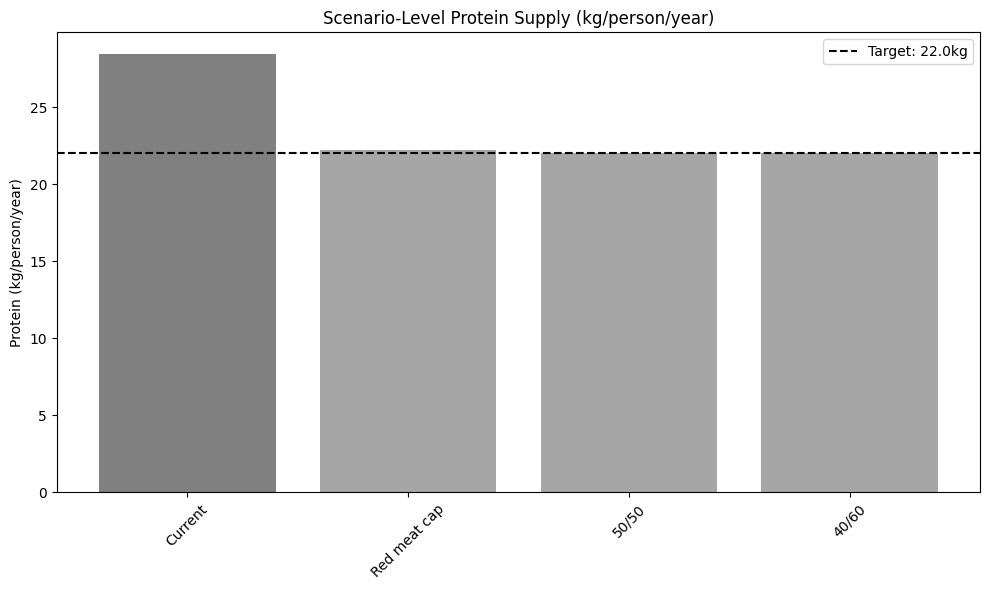

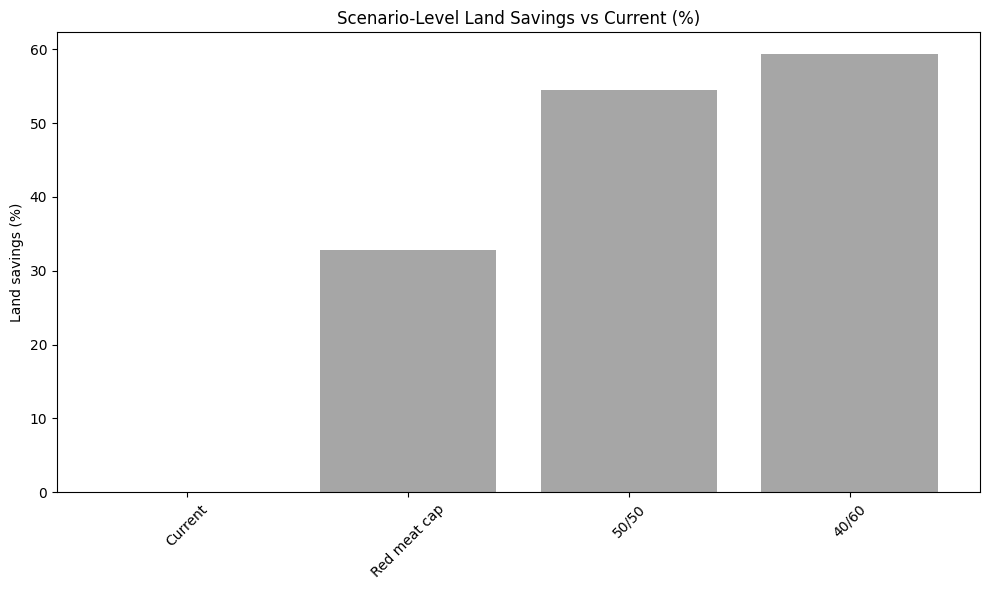

C:\Users\Eva\AppData\Local\Temp\ipykernel_21696\1295806418.py:381: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")


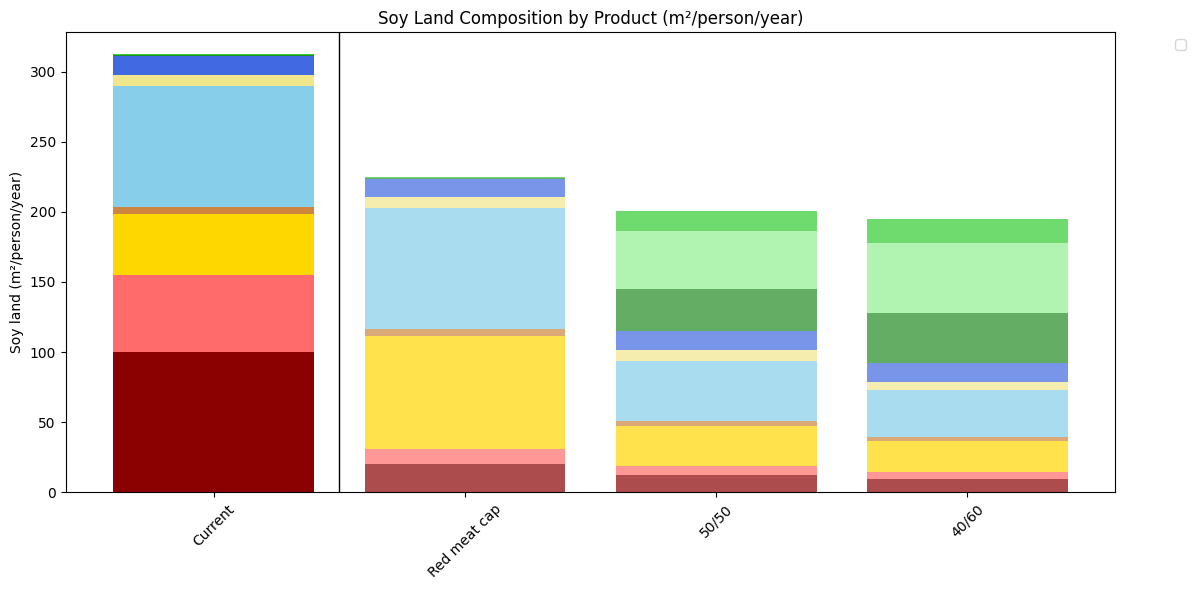

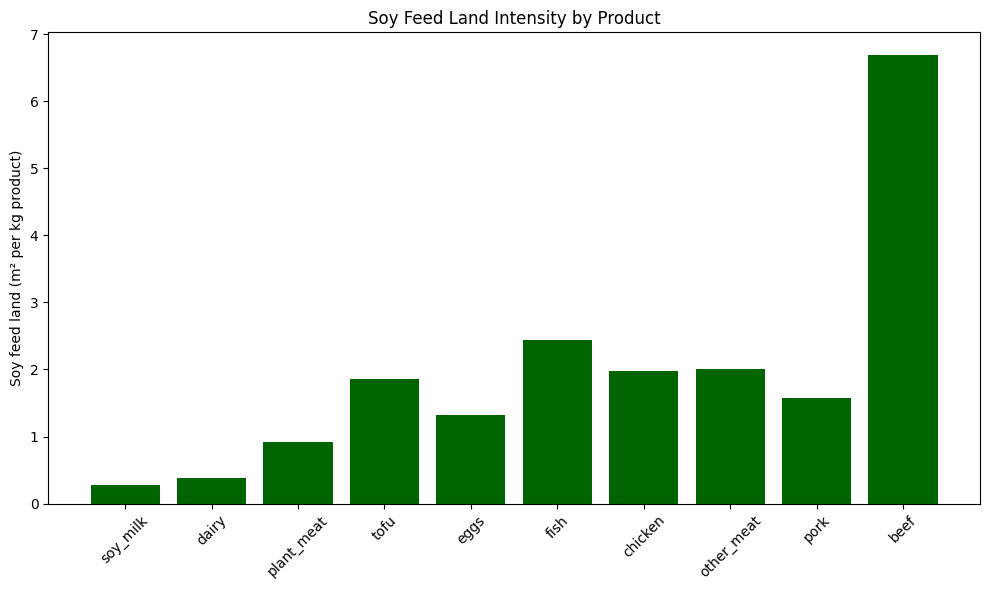

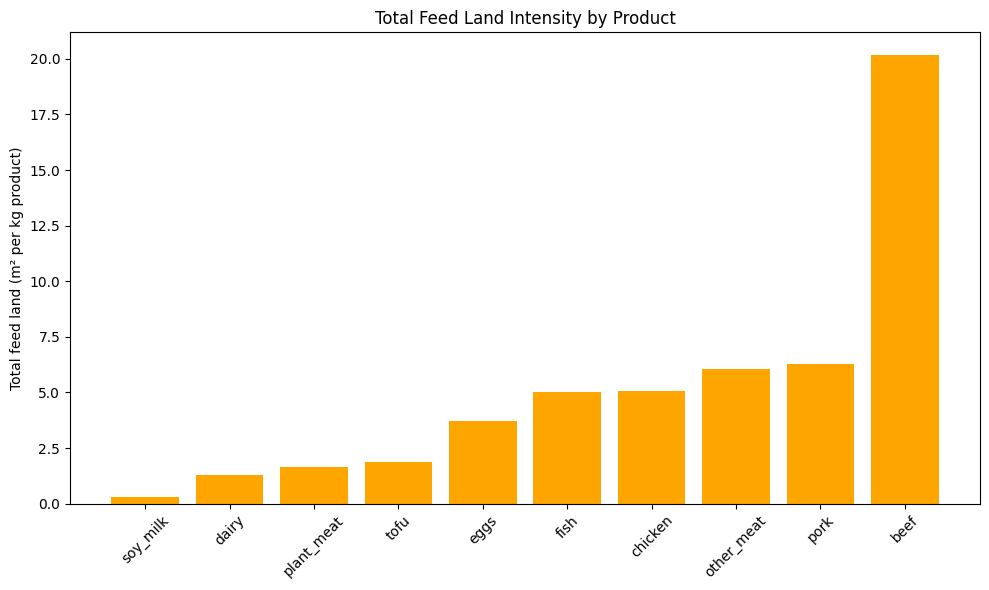

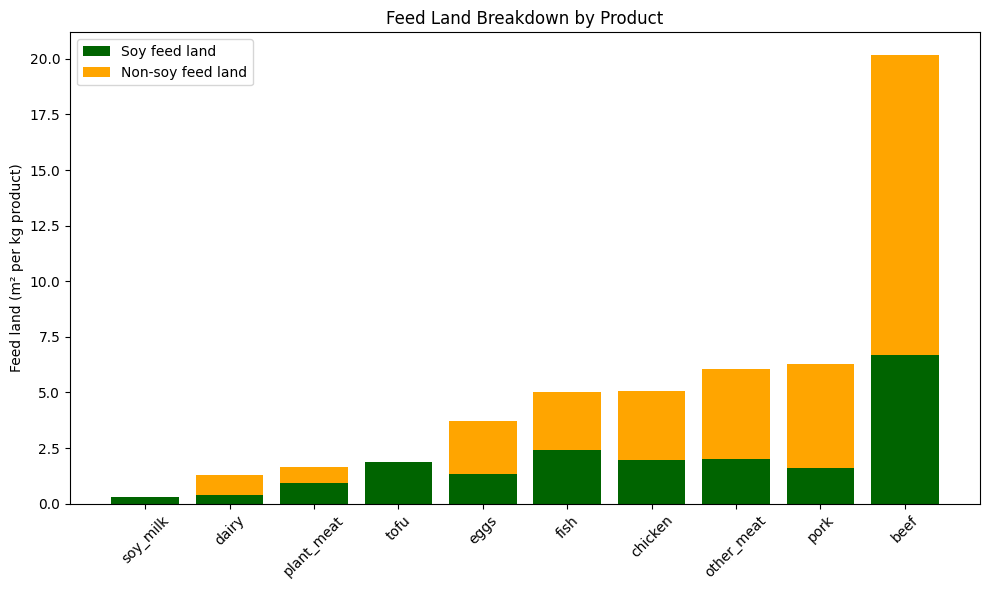

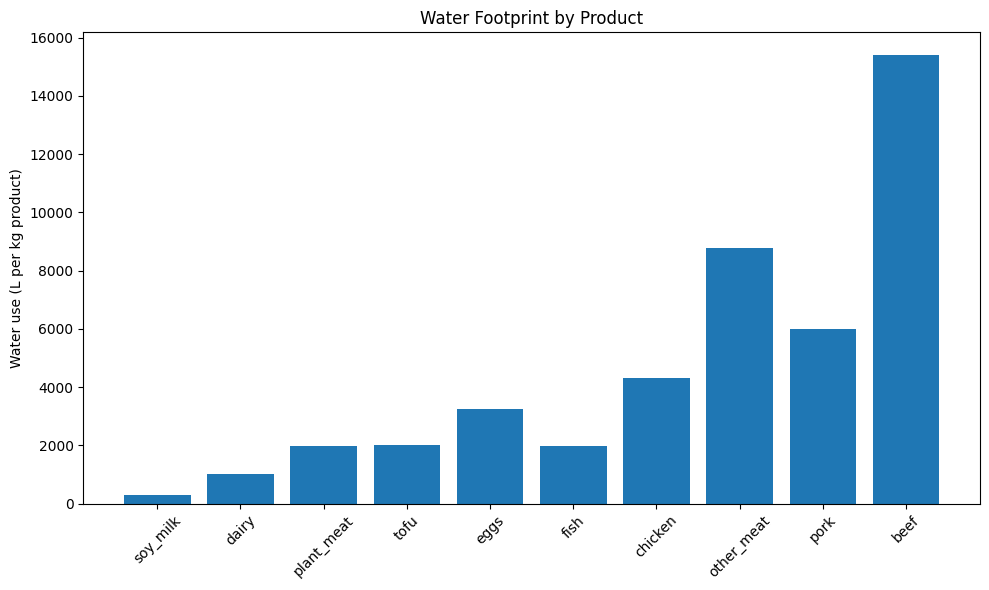

C:\Users\Eva\AppData\Local\Temp\ipykernel_21696\1295806418.py:450: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")


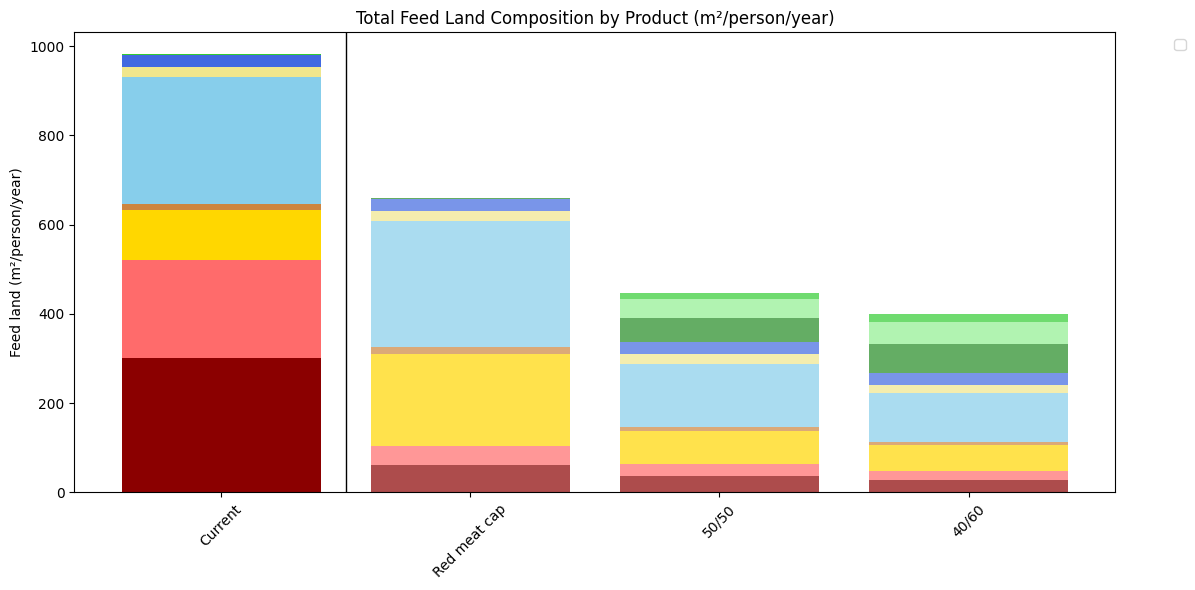

C:\Users\Eva\AppData\Local\Temp\ipykernel_21696\1295806418.py:476: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")


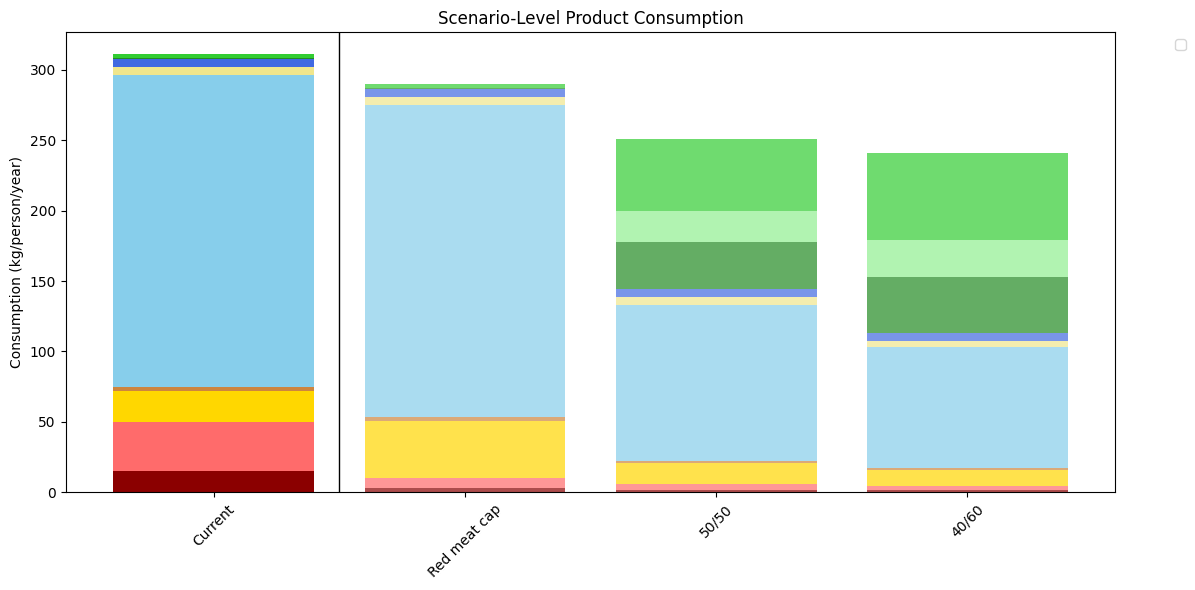

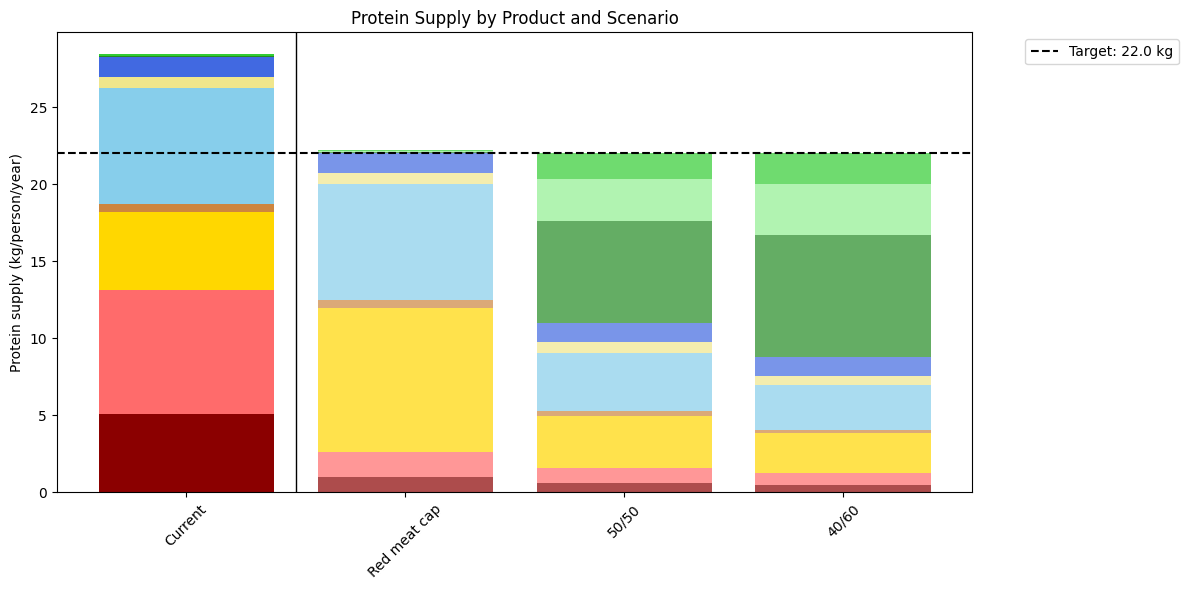

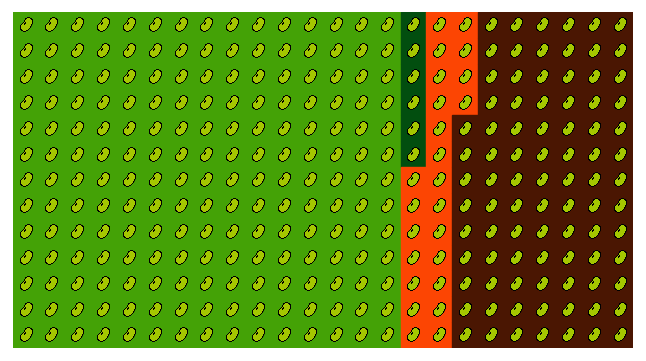

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

print("=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===")

# ============================================
# 0. CONFIG
# ============================================
NL_POPULATION = 18_044_027  # 2025
PROTEIN_TARGET = 22.0  # kg protein/person/year

# Base product consumption (kg/person/year)
meat_2024_pc = {"pork": 35.1, "chicken": 22.0, "beef": 14.9, "other_meat": 2.5}
DAIRY_KG_PC = 222.0
EGGS_KG_PC = 5.840
FISH_KG_PC = 5.475  # 15 g/day (dietary guideline)
PLANT_MEAT_KG_PC = 10_200_000 / NL_POPULATION
TOFU_KG_PC = 1_630_000 / NL_POPULATION
SOY_MILK_KG_PC = 47_100_000 / NL_POPULATION

# Feed crop land (m²/kg)
CROP_LAND_M2_KG = {"maize":0.97, "wheat":1.18, "barley":1.53, "rapeseed":2.65, "soy":2.78}

# Feed shares per product
FEED_SHARES = {
    "dairy": {"maize":0.35, "soy":0.14, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.15, "other":0.03},
    "beef": {"maize":0.25, "soy":0.12, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.35, "other":0.02},
    "pork": {"maize":0.45, "soy":0.12, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.0, "other":0.10},
    "poultry": {"maize":0.55, "soy":0.20, "wheat_barley":0.15, "rapeseed":0.05, "grass_hay":0.0, "other":0.05},
    "eggs": {"maize":0.50, "soy":0.18, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.0, "other":0.06},
    "fish": {"maize":0.20, "soy":0.25, "wheat_barley":0.30, "rapeseed":0.05, "grass_hay":0.0, "other":0.20},
    "plant_meat": {"maize":0.15, "soy":0.33, "wheat_barley":0.40, "rapeseed":0.02, "grass_hay":0.0, "other":0.10},
}

# Color mapping for products
prod_colors = {
    "beef": "#8B0000",
    "pork": "#FF6B6B",
    "chicken": "#FFD700",
    "other_meat": "#CD853F",
    "dairy": "#87CEEB",
    "eggs": "#F0E68C",
    "fish": "#4169E1",
    "plant_meat": "#228B22",
    "tofu": "#90EE90",
    "soy_milk": "#32CD32"
}

# ============================================
# 0.5 Scenario order (for plots, waffles)
# ============================================
scenario_order = ["Current", "Red meat cap", "50/50", "40/60"]

# ============================================
# 1. PRODUCTS DATAFRAME
# ============================================
products = [
    ("pork",4.74,230,"pork"),
    ("chicken",3.55,230,"poultry"),
    ("beef",20.06,340,"beef"),
    ("other_meat",6.00,200,"beef"),
    ("fish",3.50,230,"fish"),
    ("plant_meat",1.00,200,"plant_meat"),
    ("dairy",1,34,"dairy"),
    ("eggs",2.63,123,"eggs"),
    ("tofu",0.67,124,None),
    ("soy_milk",0.1,32,None)
]

df = pd.DataFrame(products, columns=["product","emcr","protein_g_kg","feed_type"])
df["soy_share"] = 0.0
df["soy_land"] = 0.0
df["non_soy_land"] = 0.0
df["total_land"] = 0.0
df["water_L_kg"] = [5988,4325,15415,8763,1974,1973,1020,3265,2000,297]

def compute_feed_land(emcr, feed_type):
    if feed_type is None:
        soy_land = emcr * CROP_LAND_M2_KG["soy"]
        return 1.0, soy_land, 0.0
    shares = FEED_SHARES[feed_type]
    soy_land = emcr * shares["soy"] * CROP_LAND_M2_KG["soy"]
    maize_kg = emcr * shares["maize"]
    wbar_kg = emcr * shares["wheat_barley"]
    rape_kg = emcr * shares["rapeseed"]
    non_soy_land = (
        maize_kg * CROP_LAND_M2_KG["maize"] +
        wbar_kg * (0.5*CROP_LAND_M2_KG["wheat"] + 0.5*CROP_LAND_M2_KG["barley"]) +
        rape_kg * CROP_LAND_M2_KG["rapeseed"]
    )
    return shares["soy"], soy_land, non_soy_land

for idx,row in df.iterrows():
    soy_share, soy_land, non_soy_land = compute_feed_land(row["emcr"], row["feed_type"])
    df.at[idx,"soy_share"]=soy_share
    df.at[idx,"soy_land"]=soy_land
    df.at[idx,"non_soy_land"]=non_soy_land
    df.at[idx,"total_land"]=soy_land+non_soy_land

# ============================================
# 2. HELPER FUNCTION
# ============================================
def add(rows, scenario, prod, kg):
    r = df.loc[df["product"]==prod].iloc[0]
    rows.append({
        "scenario": scenario,
        "product": prod,
        "kg_pc": kg,
        "protein_pc": kg * r.protein_g_kg / 1000,
        "soy_land_pc": kg * r.soy_land,
        "total_land_pc": kg * r.total_land,
        "water_pc": kg * r.water_L_kg
    })

# ============================================
# 3. SCENARIO BUILDER (FINAL LOGIC WITH OTHER MEAT)
# ============================================
def apply_red_meat_cap(animal_dict, cap_kg=10.0):
    """Apply red meat cap and fill chicken only to reach 22kg protein."""
    animal_new = animal_dict.copy()
    red_meat = ["beef","pork"]
    red_total = sum(animal_new[p] for p in red_meat)

    # Scale beef + pork if over cap
    if red_total > cap_kg:
        scale = cap_kg / red_total
        for p in red_meat:
            animal_new[p] *= scale

    # Compute total protein excluding chicken
    fixed_products = ["beef","pork","other_meat","dairy","eggs"]
    total_fixed_protein = sum([animal_new[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                               for p in fixed_products])
    total_protein_with_fish = total_fixed_protein + current_dict["fish"] * df.loc[df["product"]=="fish","protein_g_kg"].iloc[0]/1000

    # Determine chicken needed to reach exactly 22kg
    chicken_protein_per_kg = df.loc[df["product"]=="chicken","protein_g_kg"].iloc[0]/1000
    gap = PROTEIN_TARGET - total_protein_with_fish
    animal_new["chicken"] = max(0, gap / chicken_protein_per_kg)

    return animal_new


def build_scenarios():
    scenarios = []

    # --- Current diet ---
    global current_dict
    current_dict = {
        **meat_2024_pc,
        "dairy": DAIRY_KG_PC,
        "eggs": EGGS_KG_PC,
        "fish": FISH_KG_PC,
        "plant_meat": PLANT_MEAT_KG_PC,
        "tofu": TOFU_KG_PC,
        "soy_milk": SOY_MILK_KG_PC
    }

    for prod, kg in current_dict.items():
        add(scenarios,"Current",prod,kg)

    # Fixed animal protein from fish (never scaled)
    fixed_animal_protein = current_dict["fish"] * df.loc[df["product"]=="fish","protein_g_kg"].iloc[0]/1000

    # --- Red meat cap scenario ---
    animal_red = {p: current_dict[p] for p in ["beef","pork","chicken","dairy","other_meat","eggs"]}
    animal_red = apply_red_meat_cap(animal_red)

    # Add scenario
    for p, kg in animal_red.items():
        add(scenarios,"Red meat cap",p,kg)
    add(scenarios,"Red meat cap","fish",current_dict["fish"])
    for p in ["plant_meat","tofu","soy_milk"]:
        add(scenarios,"Red meat cap",p,current_dict[p])

    # --- 50/50 scenario ---
    animal_5050 = animal_red.copy()
    # Downscale beef/pork/other_meat by 10%, dairy by 50%, eggs scaled if needed
    for p in ["beef","pork","other_meat"]:
        animal_5050[p] *= 0.6
    animal_5050["dairy"] *= 0.5

    # Compute current animal protein excluding chicken
    animal_protein_fixed = sum([animal_5050[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                                for p in ["beef","pork","other_meat","dairy","eggs"]]) + fixed_animal_protein
    target_animal = PROTEIN_TARGET * 0.5
    gap = max(0,target_animal - animal_protein_fixed)

    # Chicken fills remaining animal protein
    chicken_protein_per_kg = df.loc[df["product"]=="chicken","protein_g_kg"].iloc[0]/1000
    animal_5050["chicken"] = gap / chicken_protein_per_kg

    # Plant protein = remaining to reach 22 kg
    plant_target = PROTEIN_TARGET - target_animal
    plant_shares = {"tofu":0.25,"plant_meat":0.6,"soy_milk":0.15}
    plant_5050 = {p: plant_target*plant_shares[p]/(df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000)
                   for p in plant_shares}

    # Add scenario
    for p, kg in animal_5050.items():
        add(scenarios,"50/50",p,kg)
    add(scenarios,"50/50","fish",current_dict["fish"])
    for p, kg in plant_5050.items():
        add(scenarios,"50/50",p,kg)

    # --- 40/60 scenario ---
    animal_4060 = animal_5050.copy()
    # Scale all animal products proportionally to meet 40% animal protein
    animal_protein_current = sum([animal_4060[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                                  for p in ["beef","pork","other_meat","dairy","eggs","chicken"]]) + fixed_animal_protein
    target_animal_4060 = PROTEIN_TARGET * 0.4
    scale_factor = max(0,(target_animal_4060 - fixed_animal_protein)/(animal_protein_current - fixed_animal_protein))
    for p in ["beef","pork","other_meat","dairy","eggs","chicken"]:
        animal_4060[p] *= scale_factor

    # Plant protein = remaining to reach 22 kg
    plant_target_4060 = PROTEIN_TARGET - target_animal_4060
    plant_4060 = {p: plant_target_4060*plant_shares[p]/(df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000)
                  for p in plant_shares}

    # Add scenario
    for p, kg in animal_4060.items():
        add(scenarios,"40/60",p,kg)
    add(scenarios,"40/60","fish",current_dict["fish"])
    for p, kg in plant_4060.items():
        add(scenarios,"40/60",p,kg)

    return pd.DataFrame(scenarios)

all_scenarios = build_scenarios()



# ============================================
# Scenario visual styles (Current vs scenarios)
# ============================================
scenario_style = {
    "Current": {"alpha": 1.0},
    "Red meat cap": {"alpha": 0.7},
    "50/50": {"alpha": 0.7},
    "40/60": {"alpha": 0.7},
}

# Helper: x positions for vertical separator
x_pos = {sc: i for i, sc in enumerate(agg_pc.index)}








# ============================================
# 4. SUMMARY TABLES
# ============================================
agg_pc = all_scenarios.groupby("scenario")[["soy_land_pc","total_land_pc","water_pc","protein_pc"]].sum().reindex(scenario_order)
print("\n=== SCENARIO SUMMARY ===")
print(agg_pc.round(2))

pivot = all_scenarios.pivot_table(index="scenario", columns="product", values="total_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_soy = all_scenarios.pivot_table(index="scenario", columns="product", values="soy_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_kg = all_scenarios.pivot_table(index="scenario", columns="product", values="kg_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_protein = all_scenarios.pivot_table(index="scenario", columns="product", values="protein_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)

# Full summary table
summary_table = agg_pc.join(pivot_kg.add_suffix("_kg")).join(pivot_protein.add_suffix("_protein"))
print("\n=== Full Scenario Summary Table ===")
print(summary_table.round(2))

# ============================================
# 5. SCENARIO-LEVEL PLOTS
# ============================================

# Soy land
plt.figure(figsize=(10,6))
for sc in agg_pc.index:
    plt.bar(
        sc,
        agg_pc.loc[sc, "soy_land_pc"],
        color="darkgreen",
        alpha=scenario_style[sc]["alpha"]
    )
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)
plt.title("Scenario-Level Soy Land (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total feed land
plt.figure(figsize=(10,6))
for sc in agg_pc.index:
    plt.bar(
        sc,
        agg_pc.loc[sc, "total_land_pc"],
        color="orange",
        alpha=scenario_style[sc]["alpha"]
    )
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)
plt.title("Scenario-Level Total Feed Land (m²/person/year)")
plt.ylabel("Total feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Water
plt.figure(figsize=(10,6))
for sc in agg_pc.index:
    plt.bar(
        sc,
        agg_pc.loc[sc, "water_pc"] / 1e6,
        color="blue",
        alpha=scenario_style[sc]["alpha"]
    )
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)
plt.title("Scenario-Level Water Use (million L/person/year)")
plt.ylabel("Water (million L/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Protein supply
plt.figure(figsize=(10,6))
for sc in agg_pc.index:
    plt.bar(
        sc,
        agg_pc.loc[sc, "protein_pc"],
        color="grey",
        alpha=scenario_style[sc]["alpha"]
    )
plt.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET}kg")
plt.title("Scenario-Level Protein Supply (kg/person/year)")
plt.ylabel("Protein (kg/person/year)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Land savings
plt.figure(figsize=(10,6))
current_total = agg_pc.loc["Current","total_land_pc"]
for sc in agg_pc.index:
    saving = (1 - agg_pc.loc[sc, "total_land_pc"] / current_total) * 100
    plt.bar(
        sc,
        saving,
        color="grey",
        alpha=scenario_style[sc]["alpha"]
    )


plt.title("Scenario-Level Land Savings vs Current (%)")
plt.ylabel("Land savings (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot_soy))

for prod in prod_colors:
    if prod in pivot_soy.columns:
        for i, sc in enumerate(pivot_soy.index):
            plt.bar(
                sc,
                pivot_soy.loc[sc, prod],
                bottom=bottom[i],
                color=prod_colors[prod],
                alpha=scenario_style[sc]["alpha"]
            )
        bottom += pivot_soy[prod].values
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)

plt.title("Soy Land Composition by Product (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


# ============================================
# 6. PRODUCT-LEVEL FOOTPRINTS
# ============================================

df_sorted = df.sort_values("total_land")

# Soy feed land only
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["soy_land"], color="darkgreen")
plt.ylabel("Soy feed land (m² per kg product)")
plt.title("Soy Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total feed land
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["total_land"], color="orange")
plt.ylabel("Total feed land (m² per kg product)")
plt.title("Total Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feed land breakdown (soy vs non-soy)
plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_sorted))
plt.bar(df_sorted["product"], df_sorted["soy_land"], bottom=bottom, color="darkgreen", label="Soy feed land")
bottom += df_sorted["soy_land"].values
plt.bar(df_sorted["product"], df_sorted["non_soy_land"], bottom=bottom, color="orange", label="Non-soy feed land")
plt.ylabel("Feed land (m² per kg product)")
plt.title("Feed Land Breakdown by Product")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Water footprint
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["water_L_kg"], color="tab:blue")
plt.ylabel("Water use (L per kg product)")
plt.title("Water Footprint by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
bottom = np.zeros(len(pivot))

for prod in prod_colors:
    if prod in pivot.columns:
        for i, sc in enumerate(pivot.index):
            plt.bar(
                sc,
                pivot.loc[sc, prod],
                bottom=bottom[i],
                color=prod_colors[prod],
                alpha=scenario_style[sc]["alpha"]
            )
        bottom += pivot[prod].values
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)

plt.title("Total Feed Land Composition by Product (m²/person/year)")
plt.ylabel("Feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# ============================================
# 7. SCENARIO-LEVEL PRODUCT CONSUMPTION
# ============================================

fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_kg))

for prod in prod_colors:
    if prod in pivot_kg.columns:
        for i, sc in enumerate(pivot_kg.index):
            ax.bar(
                sc,
                pivot_kg.loc[sc, prod],
                bottom=bottom[i],
                color=prod_colors[prod],
                alpha=scenario_style[sc]["alpha"]
            )
        bottom += pivot_kg[prod].values
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)

ax.set_ylabel("Consumption (kg/person/year)")
ax.set_title("Scenario-Level Product Consumption")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
bottom = np.zeros(len(pivot_protein))

for prod in prod_colors:
    if prod in pivot_protein.columns:
        for i, sc in enumerate(pivot_protein.index):
            ax.bar(
                sc,
                pivot_protein.loc[sc, prod],
                bottom=bottom[i],
                color=prod_colors[prod],
                alpha=scenario_style[sc]["alpha"]
            )
        bottom += pivot_protein[prod].values
plt.axvline(x=x_pos["Current"] + 0.5, color="black", linewidth=1)

ax.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET} kg")
ax.set_ylabel("Protein supply (kg/person/year)")
ax.set_title("Protein Supply by Product and Scenario")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Soy land per scenario (rounded for visualization) #tb checked again
soy_land_pc = {
    "Current": 312,
    "Red meat cap": 225,
    "50/50": 201,
    "40/60": 195
}

# Order from lowest to highest so each scenario shows the difference
scenario_order = ["40/60", "50/50", "Red meat cap", "Current"]

# Colors for scenarios
colors = {
    "40/60": "#44a206",
    "50/50": "#024e0f",
    "Red meat cap": "#fc4503",
    "Current": "#4A1602"
}

# Load soybean icon (transparent PNG)
icon_path = "soybean.png"
soy_icon = Image.open(icon_path)

# Waffle grid config
n_cols = 24
n_rows = 13
max_cells = n_cols * n_rows
icon_zoom = 0.05  # adjust depending on PNG size

# Compute scenario differences (to know how many squares each scenario adds)
prev = 0
scenario_diff = {}
for sc in scenario_order:
    scenario_diff[sc] = soy_land_pc[sc] - prev
    prev = soy_land_pc[sc]

# Create figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

# Remove axes, ticks, and spines
ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.axis('off')  # hides all ticks, labels, and spines

# Draw the background squares for each scenario
# Draw the background squares for each scenario (column-first)
current_idx = 0
for sc in scenario_order:
    for i in range(scenario_diff[sc]):
        # Column-first: x = column, y = row
        x = current_idx // n_rows
        y = n_rows - 1 - (current_idx % n_rows)
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=colors[sc], zorder=0))
        current_idx += 1

# Overlay soybean PNGs on every square (column-first)
for i in range(prev):  # prev = total squares
    x = i // n_rows
    y = n_rows - 1 - (i % n_rows)
    imagebox = OffsetImage(soy_icon, zoom=icon_zoom)
    ab = AnnotationBbox(imagebox, (x+0.5, y+0.5), frameon=False, zorder=1)
    ax.add_artist(ab)




plt.show()
